In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import scipy

In [2]:
with skimage.external.tifffile.TiffFile('test files\detected_image.tif') as tif:
    data = tif.asarray()
tif.close()

In [3]:
file = open('test files/detected_results.txt','r')
all_lines = file.readlines()

df_columns = all_lines[0].split('\t')
df_columns[-1] = df_columns[-1][:-1]

df = pd.DataFrame(columns = df_columns)

for line in tqdm(all_lines[1:]):
    split_line = line.split('\t')
    split_line[-1] = split_line[-1][:-1]
    line_dict = dict(zip(df_columns,split_line))
    df = df.append(line_dict, ignore_index=True)
    
file.close()

100%|██████████████████████████████████████████████████████████████████████████████| 6993/6993 [02:56<00:00, 39.56it/s]


In [4]:
df = df[df.columns[5:]].copy()
for column in df.columns:
    df[column] = df[column].apply(lambda x : float(x))

In [5]:
image_size = 2845 #number of pixels in one image dimension
image_dim = 1181.05 #length of image dimension

#calculate cell centroid coordinates as pixel
df['Centroid X pixel'] = df['Centroid X Âµm']*image_size/image_dim
df['Centroid Y pixel'] = df['Centroid Y Âµm']*image_size/image_dim

df['Centroid X pixel'] = df['Centroid X pixel'].apply(lambda x:int(x))
df['Centroid Y pixel'] = df['Centroid Y pixel'].apply(lambda x:int(x))

#for non-square image, would need to calculate x and y as separate image size and dimension

In [6]:
#drop extra columns and rename channel columns

df = df[['Centroid X pixel',
        'Centroid Y pixel',
        'Nucleus: Ch3-T1 mean',#nucleus
        'Nucleus: Ch2 GaAsP-T3 mean',#red
        'Nucleus: Ch3-T2 mean',#green
        'Nucleus: Ch1-T4 mean',#blue
        'Nucleus: Area',
        'Nucleus: Circularity']].copy()

df = df.rename(columns = {'Nucleus: Ch3-T1 mean':'nucleus',
                            'Nucleus: Ch3-T2 mean':'green',
                            'Nucleus: Ch1-T4 mean':'blue',
                            'Nucleus: Ch2 GaAsP-T3 mean':'red'})

In [7]:
#add sum of channels column
df['sum'] = df['red']+df['green']+df['blue']

In [8]:
#add columns of channel value as fraction of total
#all cells to be calculated as ratios

df['%red'] = (df['red']/df['sum'])*100
df['%green'] = (df['green']/df['sum'])*100
df['%blue'] = (df['blue']/df['sum'])*100

In [9]:
#add channel RGB image value as ratio of sum of all channels
#e.g. R=1,G=0,B=0 ratio would be rgb red = 255,rgb green = 0,rgb blue = 0
#and  R=1,G=1,B=1 ratio would be rgb red = 85,rgb green = 85,rgb blue = 85

df['rgb red'] = (df['red']/df['sum'])*255
df['rgb green'] = (df['green']/df['sum'])*255
df['rgb blue'] = (df['blue']/df['sum'])*255

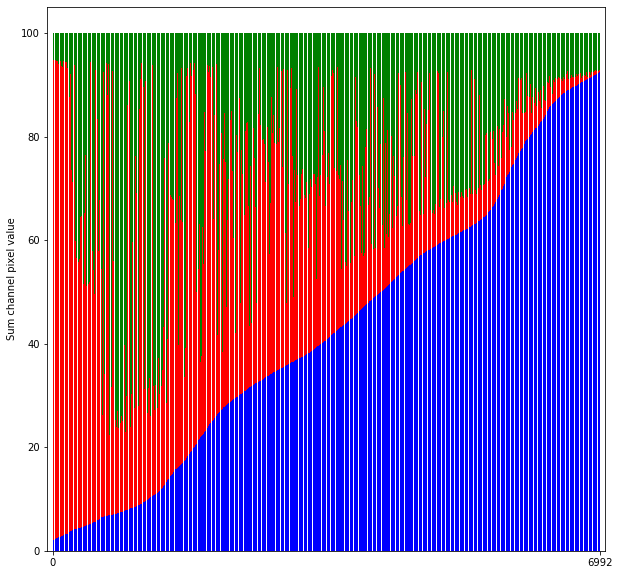

In [10]:
#show all cell channel ratios as stacked bar
sorted_df = df.sort_values(by='%blue',ascending=True).reset_index()

green = np.array(sorted_df['%green'])
red = np.array(sorted_df['%red'])
blue = np.array(sorted_df['%blue'])

ind = np.array(range(sorted_df.shape[0]))

top = (green,'g')
middle = (red,'r')
base = (blue,'b')

plt.figure(figsize=(10,10))
plt.ylabel('Sum channel pixel value')
plt.xticks([ind[0], ind[-1]], visible=True, rotation="horizontal")
plt.margins(x=0.01)

y_pos = ind

p1 = plt.bar(ind, base[0], color=base[1])
p2 = plt.bar(ind, middle[0], color = middle[1], bottom = base[0])
p3 = plt.bar(ind, top[0], color=top[1], bottom = base[0]+middle[0])

plt.show()

In [11]:
#function to generate list of coordinate tuples from df[boolean_filter]
#can generate multiple lists from any property classes

def tupleCoodinates(x,y):
    '''return x,y coordinates as tuple'''
    return (x,y)

In [12]:
def centroidMinMax(coord):
    '''return slice values which will correspond to a single cell in numpy image matrix
       can change size of slice (cell size) according to number of cells and image size'''
    
    #set min/max according to image size
    #necessary for cell centroid cooridnates that are on edge of image
    min_coord = 0
    max_coord = 2844
    
    #set minimum dimension for cell size in image
    #minimum where centroid coordinate is min or max i.e. on edge of image
    #else cell dimension will be twice minimum dimension
    minium_dimension = 5
    
    #check centroid coordinate is not on edge of image
    #if so, return min/max coordinate
    #else return slice as centroid coordinate +- minium_dimension
    if coord - minium_dimension < min_coord:
        coord_low_lim = min_coord
    else:
        coord_low_lim = coord - minium_dimension
        
    if coord + minium_dimension > max_coord:
        coord_upper_lim = max_coord
    else:
        coord_upper_lim = coord + minium_dimension
    
    return (coord_low_lim,coord_upper_lim)

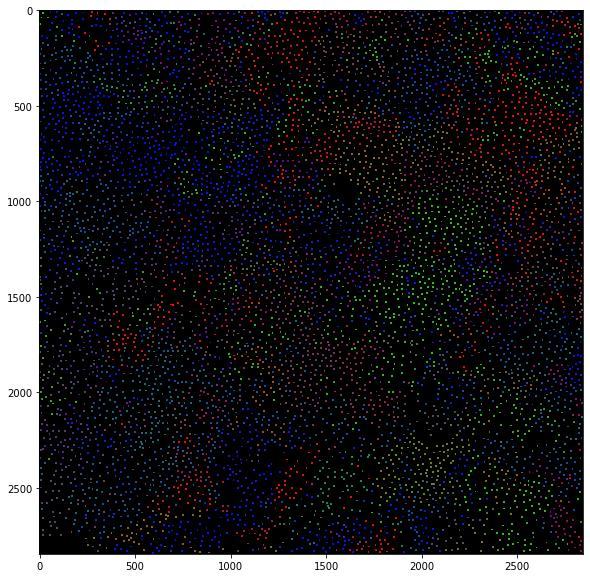

In [13]:
#return image of all cells as RGB value propetionate to ratio

#generate empty RGB matrix size of image
image = np.zeros((2845,2845,3), 'uint8')

#generate list of cell coordinate tuples from dataframe
coord_list = df[['Centroid X pixel','Centroid Y pixel']].apply(lambda x: tupleCoodinates(*x), axis=1).tolist()

#iterate through coordinates in dataframe, setting values to numpy matrix
for i in range(len(coord_list)):
    x_limits,y_limits = centroidMinMax(coord_list[i][0]),centroidMinMax(coord_list[i][1])
    image[:,:,0][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df.iloc[i].get('rgb red')
    image[:,:,1][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df.iloc[i].get('rgb green')
    image[:,:,2][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df.iloc[i].get('rgb blue')
    
plt.figure(figsize=(10,10))
plt.imshow(image)

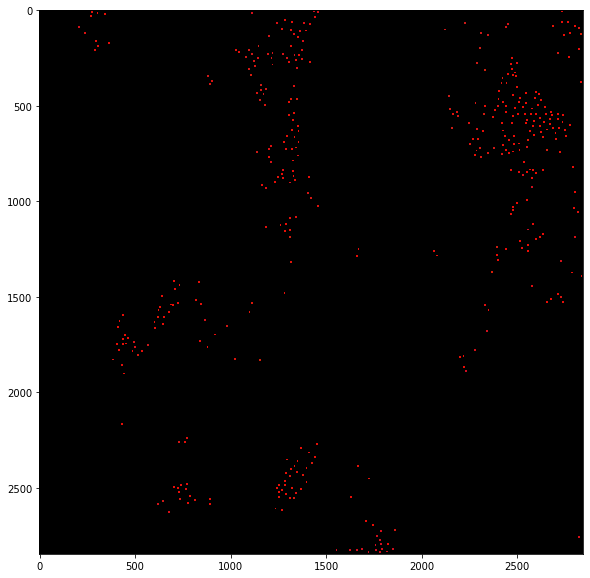

In [14]:
#boolean filters can be applied to dataframe and then coord_list generated as before
#example of only cells where red channel >= sum channel *0.8

image = np.zeros((2845,2845,3), 'uint8')
high_r = df['%red'] >= 80
df_r = df[high_r].reset_index()

coord_list = df_r[['Centroid X pixel','Centroid Y pixel']].apply(lambda x: tupleCoodinates(*x), axis=1).tolist()

#iterate through coordinates in dataframe, setting values to numpy matrix
for i in range(len(coord_list)):
    x_limits,y_limits = centroidMinMax(coord_list[i][0]),centroidMinMax(coord_list[i][1])
    image[:,:,0][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r.iloc[i].get('rgb red')
    image[:,:,1][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r.iloc[i].get('rgb green')
    image[:,:,2][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r.iloc[i].get('rgb blue')
    
plt.figure(figsize=(10,10))
plt.imshow(image)

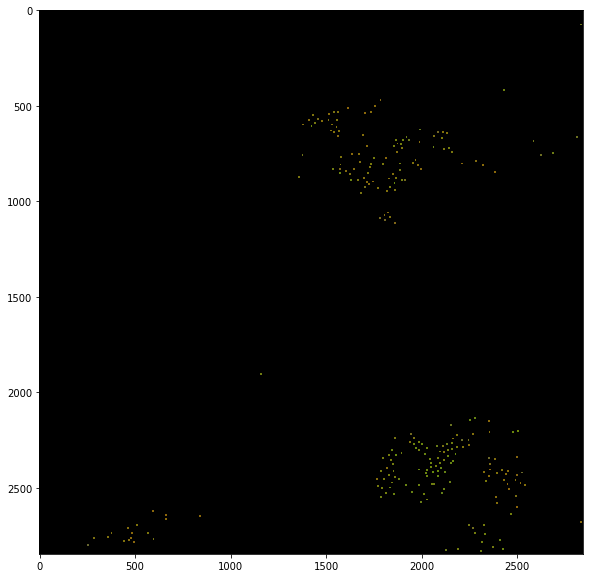

In [15]:
#example of only cells where red channel >= sum channel *0.4 AND green channel >= sum channel *0.4

image = np.zeros((2845,2845,3), 'uint8')
high_r = df['%red'] >= 40
high_g = df['%green'] >= 40
df_r_g = df[high_r & high_g].reset_index()

coord_list = df_r_g[['Centroid X pixel','Centroid Y pixel']].apply(lambda x: tupleCoodinates(*x), axis=1).tolist()

#iterate through coordinates in dataframe, setting values to numpy matrix
for i in range(len(coord_list)):
    x_limits,y_limits = centroidMinMax(coord_list[i][0]),centroidMinMax(coord_list[i][1])
    image[:,:,0][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g.iloc[i].get('rgb red')
    image[:,:,1][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g.iloc[i].get('rgb green')
    image[:,:,2][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g.iloc[i].get('rgb blue')
    
plt.figure(figsize=(10,10))
plt.imshow(image)

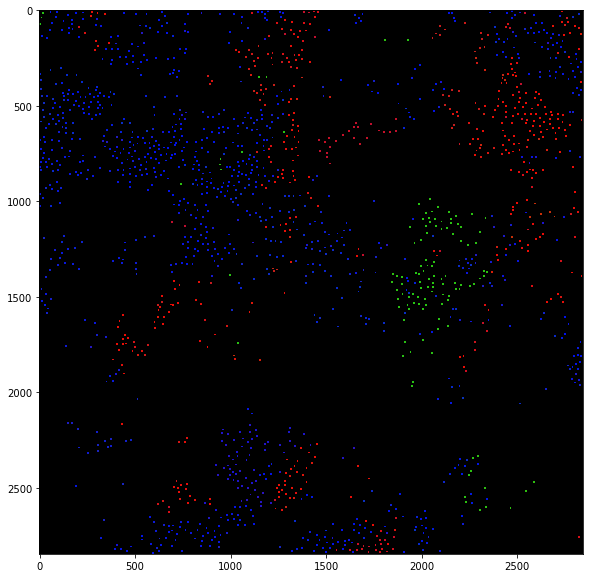

In [16]:
#example of only cells where red channel >= sum channel *0.8 OR blue channel >= sum channel *0.8 OR green channel >= sum channel *0.6

image = np.zeros((2845,2845,3), 'uint8')
high_r = df['%red'] >= 75
high_g = df['%green'] >= 75
high_b = df['%blue'] >= 75
df_r_g_b = df[high_r|high_g|high_b].reset_index()

coord_list = df_r_g_b[['Centroid X pixel','Centroid Y pixel']].apply(lambda x: tupleCoodinates(*x), axis=1).tolist()

#iterate through coordinates in dataframe, setting values to numpy matrix
for i in range(len(coord_list)):
    x_limits,y_limits = centroidMinMax(coord_list[i][0]),centroidMinMax(coord_list[i][1])
    image[:,:,0][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g_b.iloc[i].get('rgb red')
    image[:,:,1][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g_b.iloc[i].get('rgb green')
    image[:,:,2][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = df_r_g_b.iloc[i].get('rgb blue')
    
plt.figure(figsize=(10,10))
plt.imshow(image)